In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

In [28]:
data = pd.read_csv('data/runs/n_results.csv', index_col='run')
drug_data = pd.read_csv('data/runs/drug_data.csv').rename(columns={'Unnamed: 0.1':'Drug'}).drop('Unnamed: 0', axis=1)


# Data cleaning

In [29]:
data = data[data['status']=='completed']
data = data[data['r_2_mean'].notnull()]

data['time'] = pd.to_timedelta(data['time'])
data['started'] = pd.to_datetime(data['started'])
data['seconds'] = data['time'].apply(lambda x:x.seconds)

data['datasets'] = data['gdsc']+data['ctrp']+data['ccle']
data = data[data['datasets']>0]

# The only valid daata
ndata = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

# Joint drug data
drug_data_j = drug_data.join(ndata, rsuffix='_drug', on='run')
drug_data_j = drug_data_j[drug_data_j['started'].notnull()]
ndrug_data = drug_data_j[drug_data_j['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full_data = drug_data.join(data, on='run', rsuffix='_drug')

In [30]:
ndata.describe()

,time,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,3901,1813.000000,3901.0,3901.000000,3901.000000,0.0,3901.00,3901.0,3901.000000,3900.000000,3901.000000
mean,0 days 00:58:26.734427,2.020408,4.0,19.995129,0.097727,NaN,0.01,0.0,0.060908,0.229286,3418.141759
std,0 days 01:45:41.426394,0.805693,0.0,0.304204,0.056837,NaN,0.00,0.0,0.291535,1.016499,5583.322548
min,0 days 00:00:33,1.000000,4.0,1.000000,0.000853,NaN,0.01,0.0,-10.539266,0.000876,33.000000
25%,0 days 00:09:18,1.000000,4.0,20.000000,0.047648,NaN,0.01,0.0,-0.020325,0.094116,558.000000
50%,0 days 00:30:23,2.000000,4.0,20.000000,0.097354,NaN,0.01,0.0,0.085522,0.128460,1823.000000
75%,0 days 01:06:33,3.000000,4.0,20.000000,0.145949,NaN,0.01,0.0,0.176236,0.197914,3993.000000
max,1 days 04:49:17,3.000000,4.0,20.000000,0.199802,NaN,0.01,0.0,0.414408,42.588642,82747.000000


# Per model

In [110]:
nmodels = ndata.groupby('model').median()
nmodels['Number of runs'] = [data[(data['model']==i) & (data['started'] > pd.to_datetime('2020-04-15 18:00:00'))].shape[0] for i in nmodels.index]
nmodels

,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds,Number of runs
model,,,,,,,,,,,
DecisionTreeRegressor,2.0,4.0,20.0,0.097869,NaN,0.01,0.0,-0.078007,0.186813,1035.0,915
ElasticNet,2.0,4.0,20.0,0.095198,NaN,0.01,0.0,0.108096,0.100632,1772.0,1181
KNeighborsRegressor,2.0,4.0,20.0,0.089228,NaN,0.01,0.0,0.107251,0.118816,6525.5,452
RandomForestRegressor,2.0,4.0,20.0,0.089267,NaN,0.01,0.0,0.113352,0.116625,2869.0,763
SVR,2.0,4.0,20.0,0.113707,NaN,0.01,0.0,-0.028523,0.223193,1169.0,590


# AJIVE analysis

In [121]:
multiple = ndata[ndata['datasets']>1]
multiple.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,2165.000000,2164.000000,2165.000000
mean,0.123763,0.129690,4398.476674
std,0.140700,0.111122,6245.248131
min,-0.487365,0.000876,58.000000
25%,-0.005191,0.075327,884.000000
50%,0.123579,0.115254,2845.000000
75%,0.242751,0.171182,5279.000000
max,0.414408,2.029289,78169.000000


In [31]:
ajive = ndata[ndata['ajive'].notnull()]
ajive.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,1813.000000,1812.000000,1813.000000
mean,0.090175,0.206724,2983.418092
std,0.174732,0.333364,5520.000507
min,-1.592165,0.008371,33.000000
25%,0.031340,0.103582,477.000000
50%,0.106427,0.134383,1613.000000
75%,0.205853,0.202207,3561.000000
max,0.414408,5.348681,82747.000000


In [41]:
drug_data[drug_data['Drug']=='17-AAG'].shape[0]

925

# Hard to predict drugs

In [45]:
drugs = drug_data.groupby('Drug').agg({'r2_score': ['mean', 'std']})
drugs['runs'] = [drug_data[drug_data['Drug']==i].shape[0] for i in drugs.index]

In [107]:
drugs.sort_values(('r2_score', 'mean')).head()

r2_score            runs
                    mean        std     
Drug                                    
BRD-K13185470 -58.203728  96.803238    9
BRD-K27986637 -12.097895  38.586520   16
BRD-K78574327  -5.360068   5.870280    7
ML312          -4.405817  11.656311   11
BRD-K86535717  -3.959748   8.741852    8

In [106]:
outliers = pd.DataFrame(columns=['ctrp', 'datasets', 'r2_score'])
for i in drugs[drugs['runs']<50].index:
    dr = drug_data_j[drug_data_j['Drug']==i]
    
    outliers.loc[i] = [dr['ctrp'].mean(), dr['datasets'].mean(), dr['r2_score'].mean()]

In [104]:
outliers.describe()

,ctrp,datasets,r2_score
count,538.000000,538.0,538.000000
mean,0.860595,1.0,-0.117212
std,0.346691,0.0,1.791620
min,0.000000,1.0,-40.510015
25%,1.000000,1.0,-0.083149
50%,1.000000,1.0,0.005191
75%,1.000000,1.0,0.111235
max,1.000000,1.0,0.470586


In [158]:
one = drugs[drugs['runs']<50].sort_values(by=('r2_score', 'mean'), ascending=False)
one.describe()

r2_score                    runs
             mean         std            
count  553.000000  553.000000  553.000000
mean    -0.015132    0.735202   13.090416
std      2.580667    4.468279    8.431037
min    -58.203728    0.028078    2.000000
25%      0.058040    0.289981    8.000000
50%      0.200756    0.374798   10.000000
75%      0.327097    0.454741   13.000000
max      0.628195   96.803238   48.000000

In [201]:
multiple = drugs[drugs['runs']>50].sort_values(by=('r2_score', 'mean'), ascending=False)
multiple.describe()

r2_score                   runs
            mean        std            
count  73.000000  73.000000   73.000000
mean    0.290655   0.401838  284.561644
std     0.103026   0.132450  304.164840
min    -0.288445   0.316389   93.000000
25%     0.260616   0.370507  107.000000
50%     0.294577   0.379425  117.000000
75%     0.335637   0.400233  425.000000
max     0.467752   1.477770  951.000000

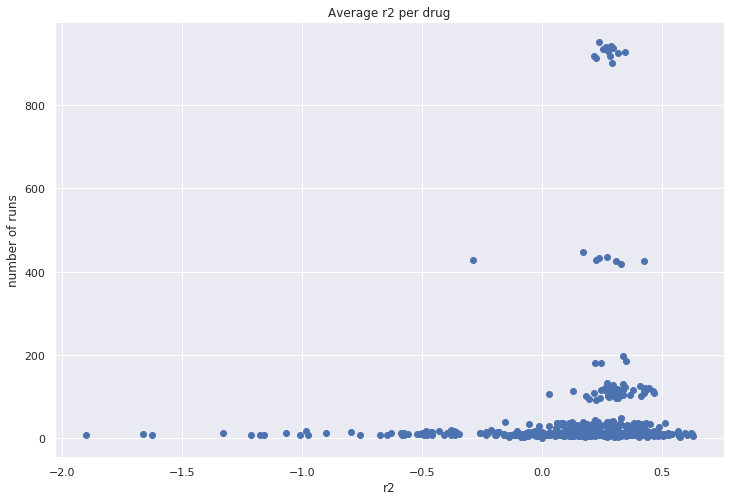

In [71]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(drugs[drugs['r2_score']['mean']>-2]['r2_score']['mean'], drugs[drugs['r2_score']['mean']>-2]['runs'])
ax.set_xlabel('r2')
ax.set_ylabel('number of runs')
ax.set_title('Average r2 per drug')
plt.savefig('Drug r2.png')

In [212]:
low = drug_data_j[drug_data_j['Drug'].isin(one.index)]
high = drug_data_j[drug_data_j['Drug'].isin(multiple[-10:-5].index)]

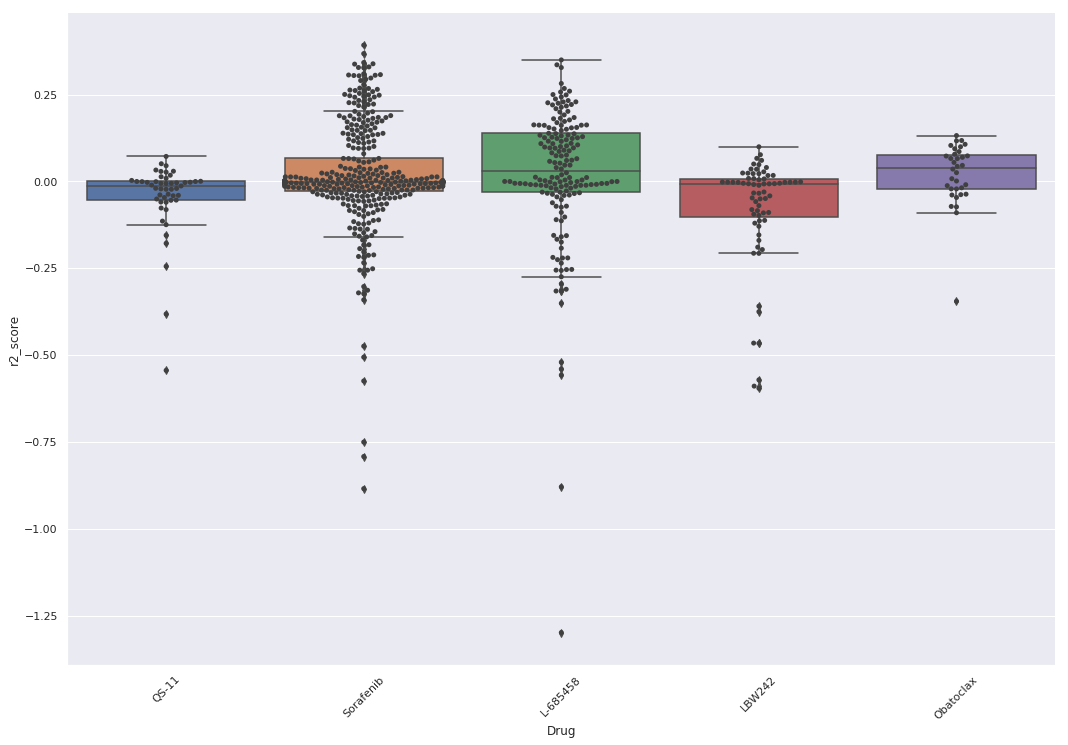

In [260]:
sns.set(font_scale=1)

g = sns.catplot(x= 'Drug', y='r2_score',data=high, kind='box', height=10, aspect=1.5)
sns.swarmplot(x= 'Drug', y='r2_score',data=high, color='.25')
g.set_xticklabels(rotation=45)


# Best performing models on hardest drugs

In [267]:
split = pd.concat([low, high], keys=['easy', 'hard']).reset_index().rename(columns={'level_0':'type'}).drop('level_1', axis=1)

,type,run,C,Drug,algorithm,alpha,bootstrap,cache_size,coef0,copy_X,...,model,n,norm,test,threshold,step,r_2_mean,r_2_std,seconds,datasets
0,easy,f1adf025,NaN,AZD1480,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
1,easy,f1adf025,NaN,BRD-K03911514,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
2,easy,f1adf025,NaN,BRD-K33514849,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
3,easy,f1adf025,NaN,BRD-K55116708,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
4,easy,f1adf025,NaN,BRD-K92856060,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
5,easy,f1adf025,NaN,BRD4132,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
6,easy,f1adf025,NaN,Carboplatin_etoposide 40 to 17 ratio mol by mol,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
7,easy,f1adf025,NaN,Decitabine_navitoclax 2 to 1 ratio mol by mol,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
8,easy,f1adf025,NaN,GSK461364,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1
9,easy,f1adf025,NaN,HC-067047,NaN,NaN,NaN,NaN,NaN,NaN,...,DecisionTreeRegressor,0.110765,StandardScaler,NaN,0.01,0.0,-0.289418,0.998260,127.0,1


In [237]:
hard = low.groupby(['model', 'fs']).mean()[['r2_score', 'r_2_std']].reset_index()

In [238]:
easy = high.groupby(['model', 'fs']).mean()[['r2_score', 'r_2_std']].reset_index()

In [246]:
split = pd.concat([easy, hard], keys=['easy', 'hard']).reset_index().rename(columns={'level_0':'type'}).drop('level_1', axis=1)

Text(0.5, 0.98, 'Differences in feature selection between easy and hard models')

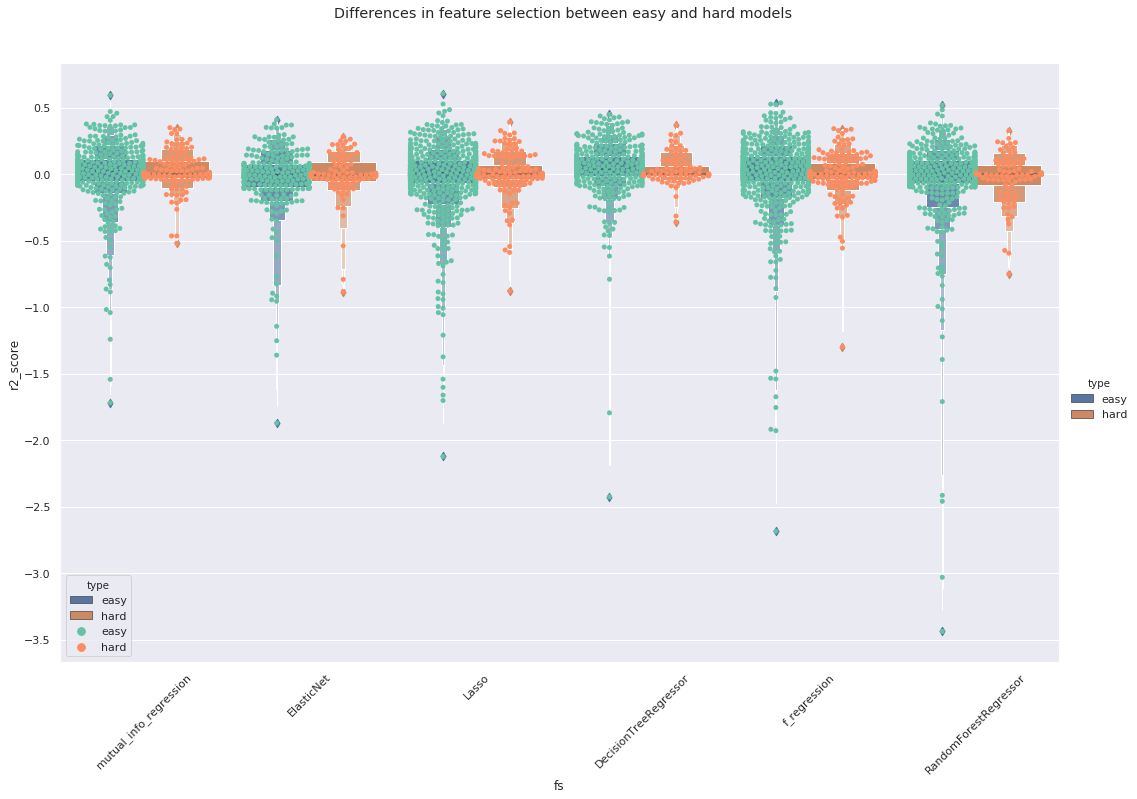

In [281]:
g = sns.catplot(x='fs', y='r2_score', hue='type', data=split[split['r2_score']>-4], kind='boxen', height=10, aspect=1.5)
sns.swarmplot(x='fs', y='r2_score', hue='type',dodge=True, data=split[split['r2_score']>-4], ax=g.ax, palette='Set2')
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Differences in feature selection performance between easy and hard models')

Text(0.5, 0.98, 'Differences in feature selection between easy and hard models')

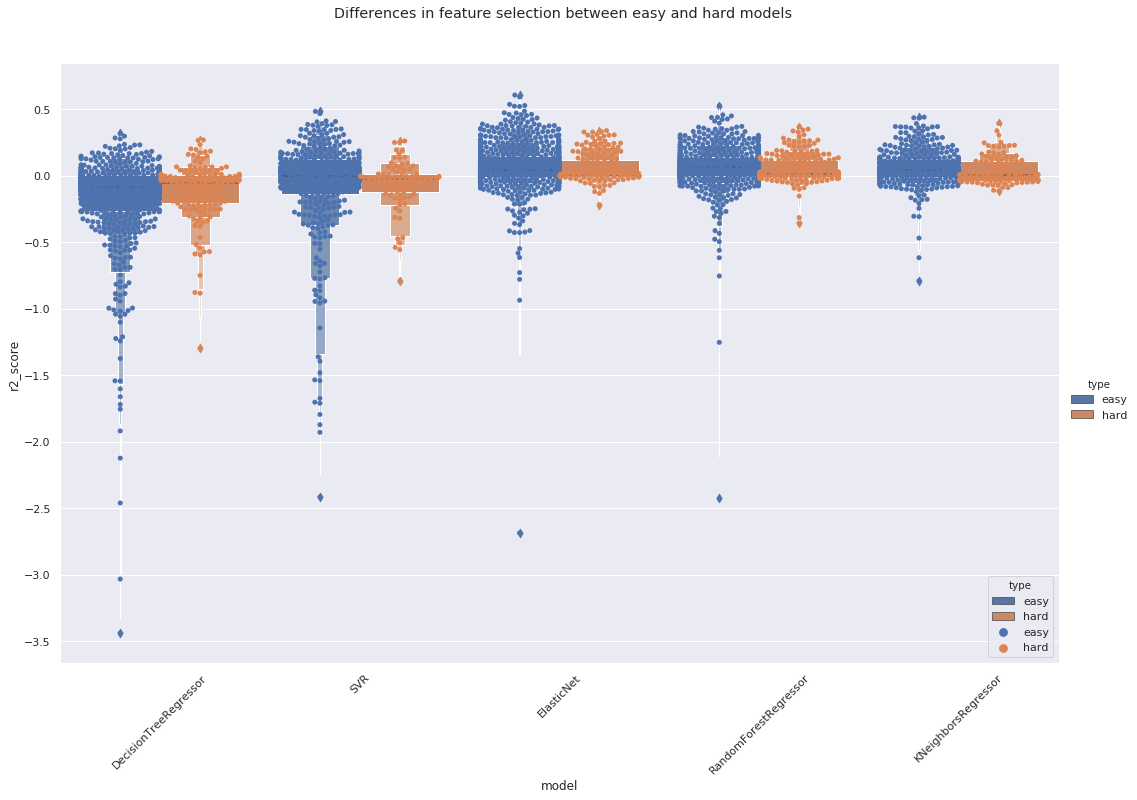

In [280]:
g = sns.catplot(x='model', y='r2_score', hue='type', data=split[split['r2_score']>-4], kind='boxen', height=10, aspect=1.5)
sns.swarmplot(x='model', y='r2_score', hue='type',dodge=True, data=split[split['r2_score']>-4], ax=g.ax)
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Differences in model performance between easy and hard models')

# Influence of n on r2

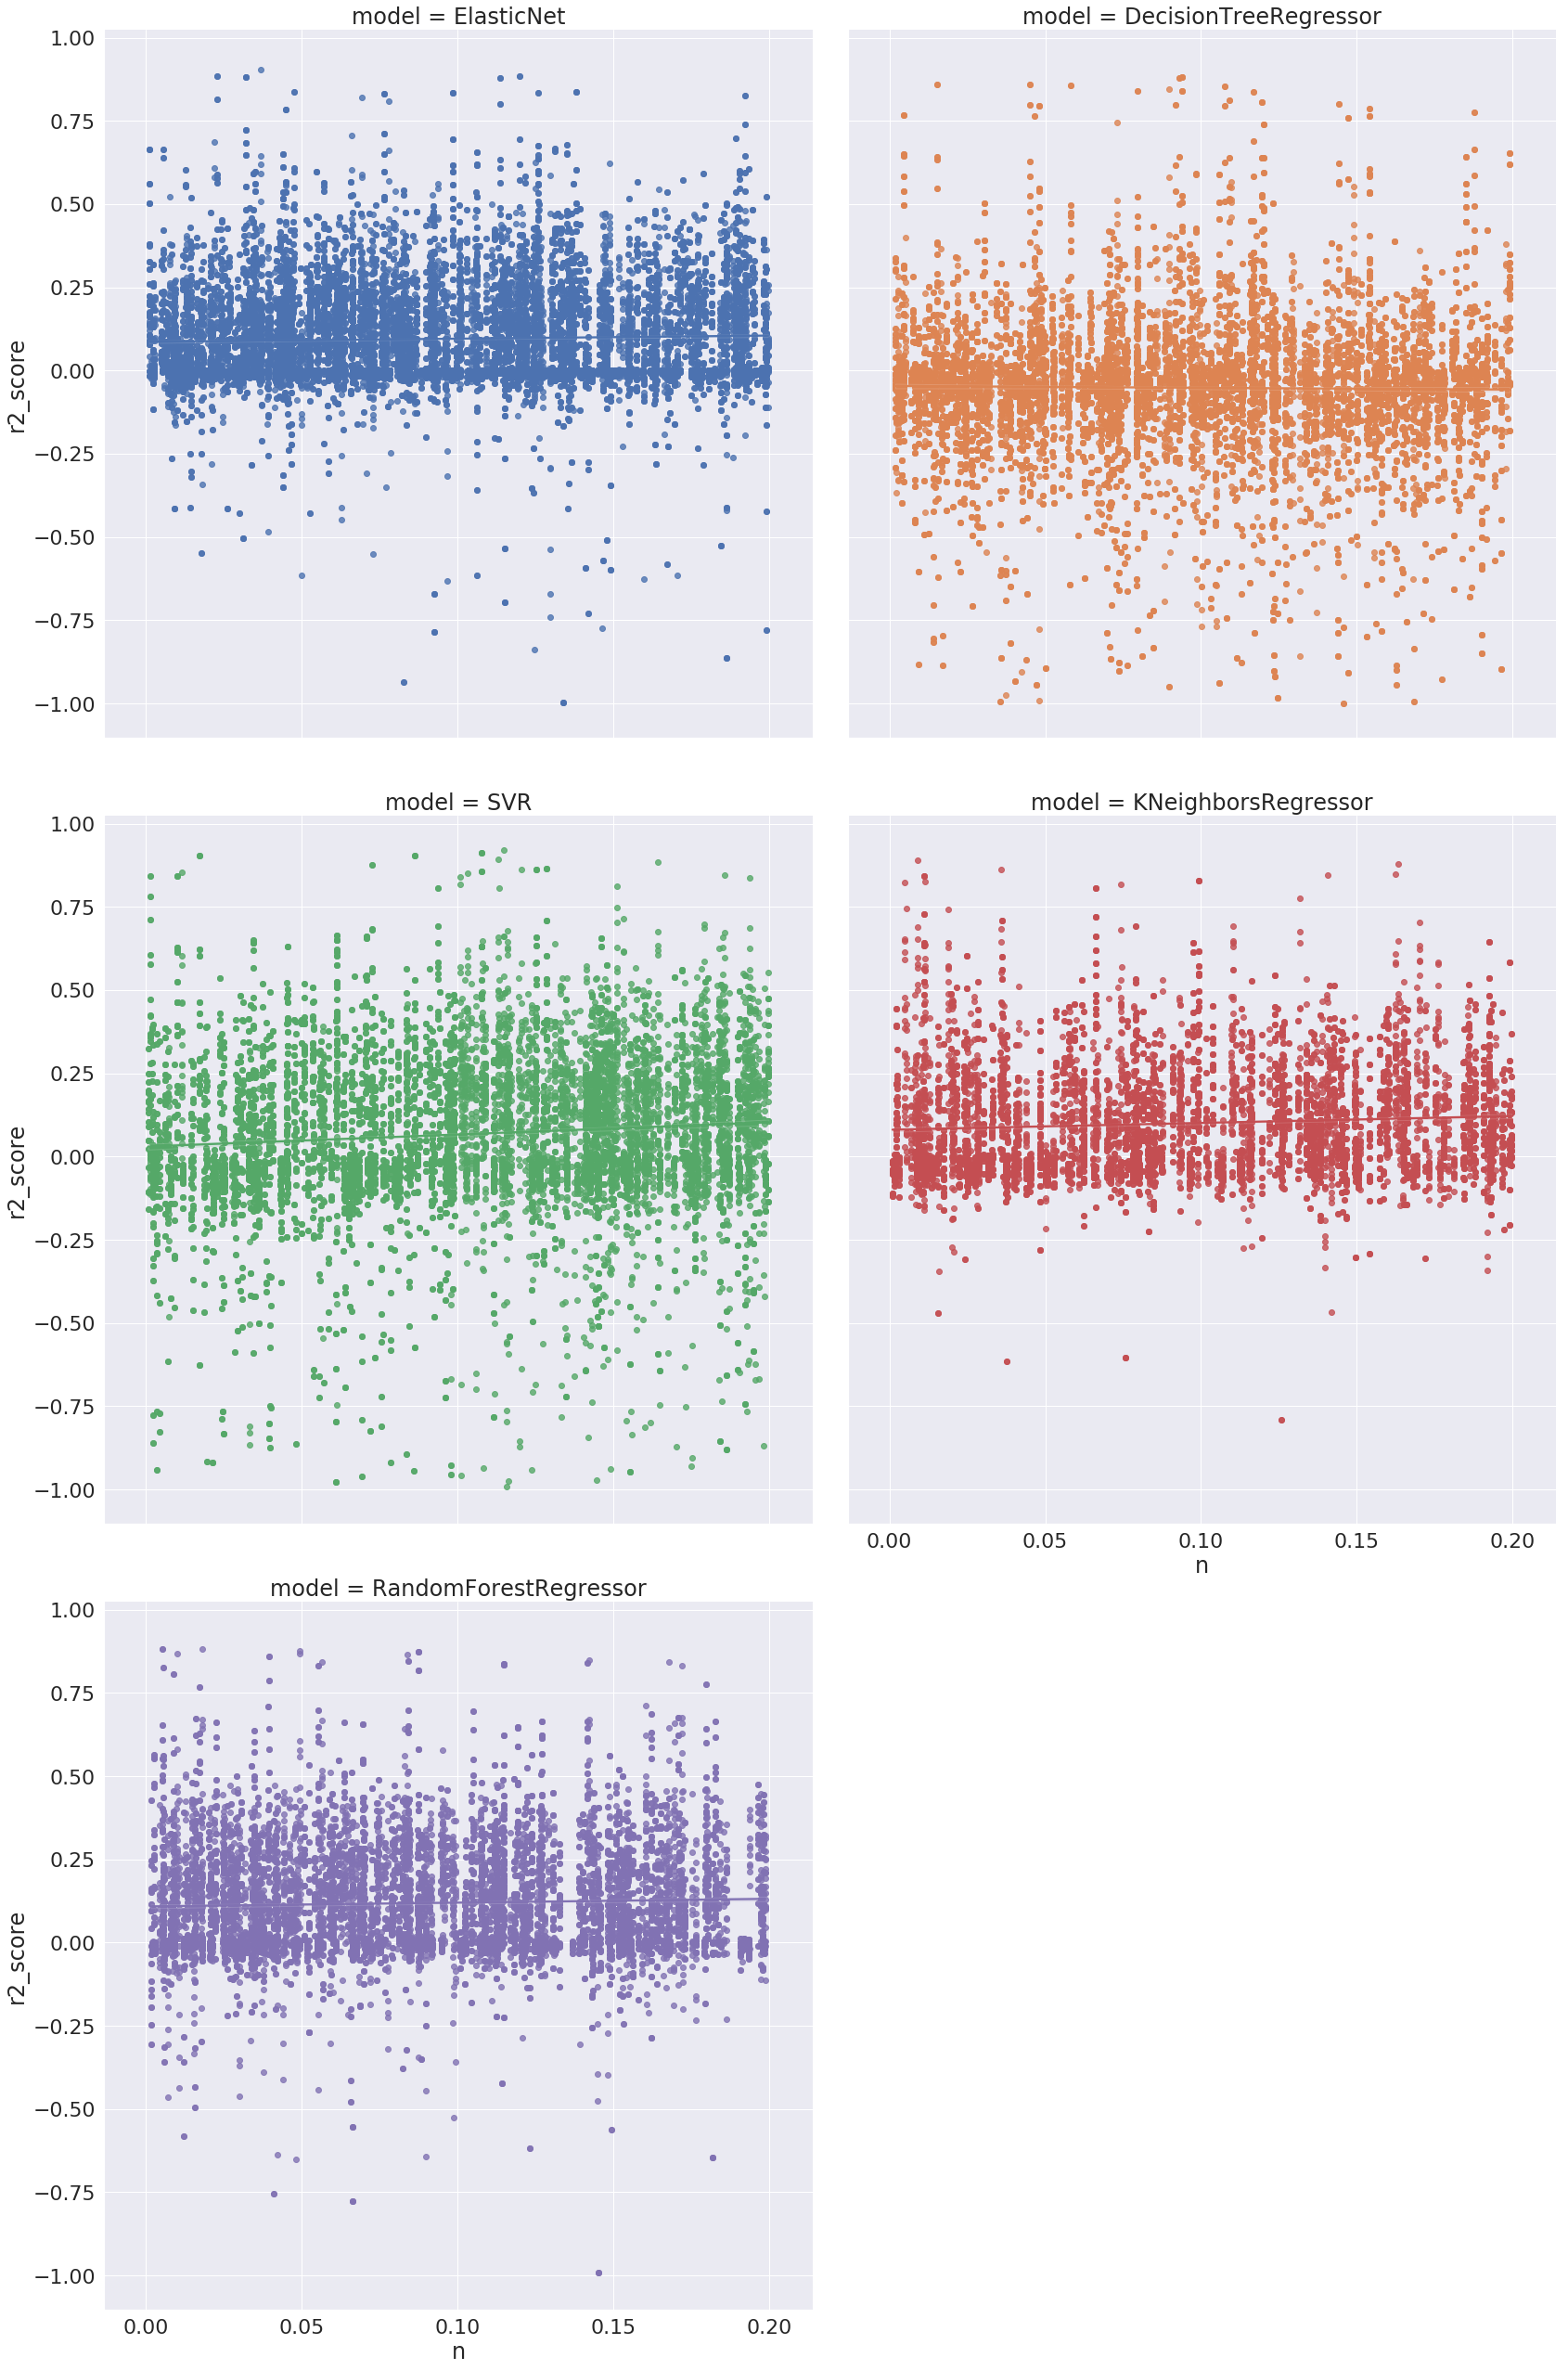

In [111]:
sns.set(font_scale=2)
g = sns.lmplot(x='n', y='r2_score', data=drug_data_j[drug_data_j['r2_score']>-1], col='model', hue='model', col_wrap=2, height=12, legend=False)
#plt.savefig('model vs n')